# Kaggle Titanic Prediction

## Importing libraries and reading data

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, make_scorer

In [90]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [91]:
train_set['Pclass'] = train_set['Pclass'].astype(str)
test_set['Pclass'] = test_set['Pclass'].astype(str)

In [92]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA

### Numerical features

In [93]:
def plot_histogram(df, feature):
    sns.histplot(data=df, x=feature, hue="Survived", multiple="stack")
    plt.show()

In [94]:
numerical_cols = train_set.select_dtypes(exclude= 'object').columns[2:]
numerical_cols

Index(['Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

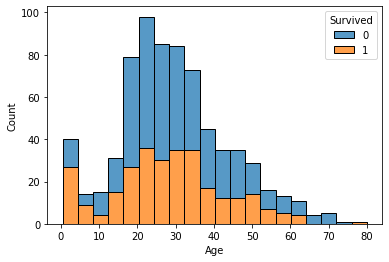

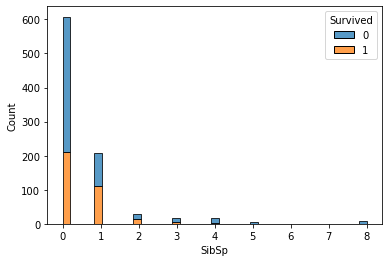

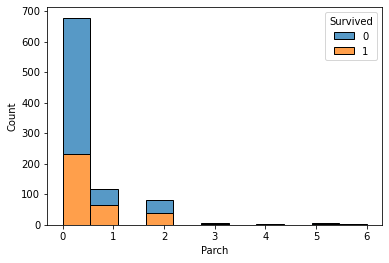

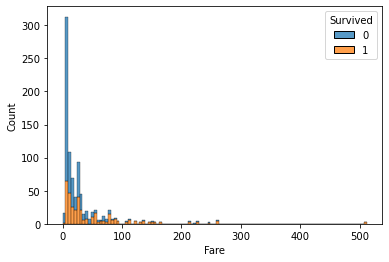

In [95]:
for col in numerical_cols:
    plot_histogram(train_set, col)

### Categorical features

In [96]:
train_set['Has_Cabin_Letter'] = (~train_set.Cabin.isnull()).astype(object)
test_set['Has_Cabin_Letter'] = (~train_set.Cabin.isnull()).astype(object)

In [97]:
categorical_cols = train_set.select_dtypes(include= 'object').columns.to_list()
categorical_cols.remove('Name')
categorical_cols.remove('Ticket')
categorical_cols.remove('Cabin')
categorical_cols

['Pclass', 'Sex', 'Embarked', 'Has_Cabin_Letter']

In [98]:
def plot_bar_chart(df, feature):
    df_aux = df.copy()
    df_aux[feature] = df_aux[feature].fillna('Null')
    sns.catplot(y=feature, hue="Survived", kind="count", data=df_aux)
    plt.show()

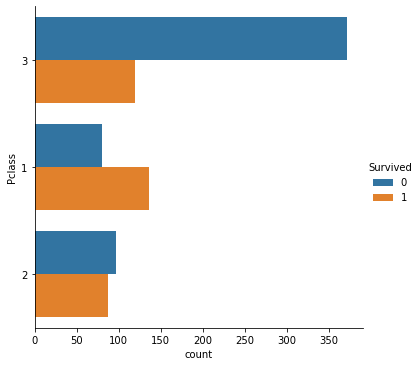

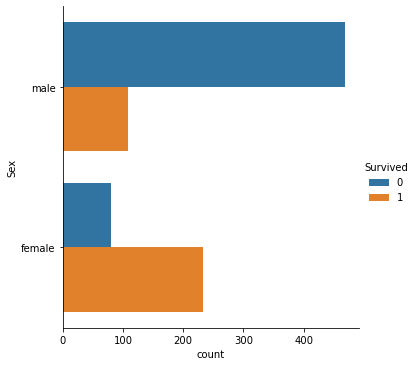

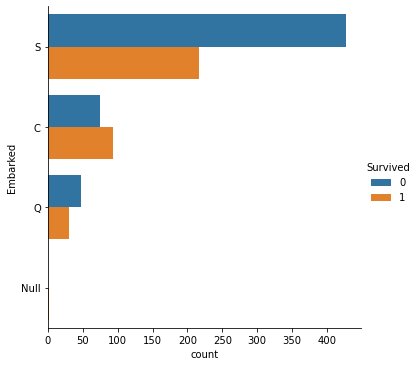

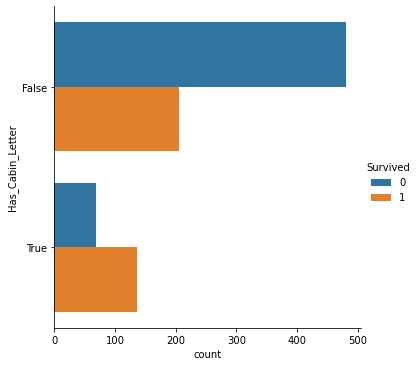

In [99]:
for col in categorical_cols:
    plot_bar_chart(train_set, col)

In [100]:
train_set['Has_Cabin_Letter'] = (~train_set.Cabin.isnull())*1
test_set['Has_Cabin_Letter'] = (~train_set.Cabin.isnull())*1

In [114]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Has_Cabin_Letter']
X = train_set[features]
y = train_set['Survived']

X_test = test_set[features]

## Data Prep

Spliting data in training and validation sets

In [115]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2, random_state=42, stratify = y)

In [103]:
X_train.isnull().mean()

Pclass              0.000000
Sex                 0.000000
Age                 0.192416
Fare                0.000000
Embarked            0.002809
Has_Cabin_Letter    0.000000
dtype: float64

Handling missing values

In [116]:
missing_values_dict = {
    'age_median': X_train.Age.median(),
    'embarked_mode' : mode(train_set['Embarked']),
    'fare_mode' : mode(train_set['Fare'])
}

In [118]:
def fill_missing_data(df, missing_values_dict):

    new_df = df.copy()

    new_df['Age'] = new_df['Age'].fillna(missing_values_dict['age_median'])
    new_df['Embarked'] = new_df['Embarked'].fillna(missing_values_dict['embarked_mode'])
    new_df['Fare'] = new_df['Fare'].fillna(missing_values_dict['fare_mode'])

    return new_df

In [119]:
X_train = fill_missing_data(X_train, missing_values_dict)
X_val = fill_missing_data(X_val, missing_values_dict)
X_test = fill_missing_data(X_test, missing_values_dict)

Handling the categorical data

In [120]:
def apply_one_hot_encoding(df, feature, encoder):

    one_hot_enc_df = encoder.transform(df[feature].values.reshape(-1,1)).toarray()
    enc_df = pd.DataFrame(one_hot_enc_df, columns = encoder.categories_[0][1:].tolist())
    
    new_cols_names = {col: feature + '_' + col for col in enc_df.columns}
    enc_df = enc_df.rename(columns = new_cols_names)

    final_df = pd.concat([df.reset_index(), enc_df], axis = 1).drop(columns = ['index', feature])
    return final_df

In [121]:
def feature_one_hot_encoding(X_train, X_val, X_test, feature):
    
    encoder = OneHotEncoder(drop='first').fit(X_train[feature].values.reshape(-1,1))

    X_train = apply_one_hot_encoding(X_train, feature, encoder)
    X_val = apply_one_hot_encoding(X_val, feature, encoder)
    X_test = apply_one_hot_encoding(X_test, feature, encoder)

    return X_train, X_val, X_test

In [122]:
X_train, X_val, X_test = feature_one_hot_encoding(X_train, X_val, X_test, 'Embarked')
X_train, X_val, X_test = feature_one_hot_encoding(X_train, X_val, X_test, 'Sex')
X_train, X_val, X_test = feature_one_hot_encoding(X_train, X_val, X_test, 'Pclass')

In [123]:
X_train

,Age,Fare,Has_Cabin_Letter,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
0,28.5,56.4958,0,0.0,1.0,1.0,0.0,1.0
1,28.5,0.0000,0,0.0,1.0,1.0,1.0,0.0
2,28.5,221.7792,1,0.0,1.0,1.0,0.0,0.0
3,18.0,9.3500,0,0.0,1.0,0.0,0.0,1.0
4,31.0,26.2500,0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
707,28.5,7.8792,0,1.0,0.0,0.0,0.0,1.0
708,35.0,512.3292,0,0.0,0.0,0.0,0.0,0.0
709,48.0,34.3750,0,0.0,1.0,0.0,0.0,1.0
710,47.0,38.5000,1,0.0,1.0,1.0,0.0,0.0


## Auxiliary functions

In [124]:
def plot_balanced_accuracy_heatmap(y, y_pred):

  print(f'Balanced accuracy:{balanced_accuracy_score(y, y_pred)}\n')

  plt.figure(figsize=(8,8))
  sns.heatmap(
      confusion_matrix(y, y_pred, normalize='true').round(2), 
      cmap='Blues', 
      annot=True
  ).set(xlabel='Predicted', ylabel='Expected')
  plt.show()

## Baseline

In [125]:
dt_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt_classifier.fit(X_train, y_train)

baseline_train_pred = dt_classifier.predict(X_train)
baseline_val_pred = dt_classifier.predict(X_val)

Balanced accuracy:0.7868906455862978



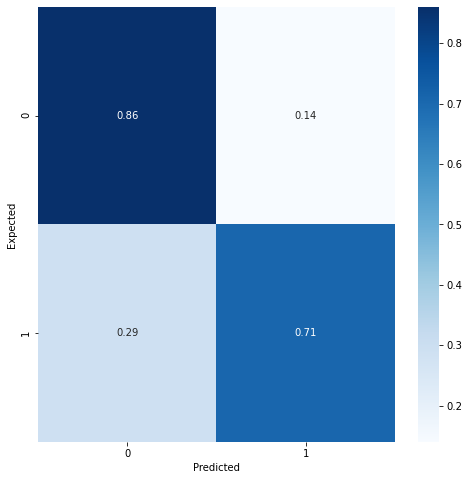

In [126]:
plot_balanced_accuracy_heatmap(y_val, baseline_val_pred)

## SVM & Grid Search

In [127]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [66]:
C_range = np.logspace(-2, 2, 5)
kernels = ['linear', 'rbf', 'sigmoid']
param_grid = dict(C=C_range, kernel=kernels)
print('param_grid:', param_grid)


param_grid: {'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'kernel': ['linear', 'rbf', 'sigmoid']}


In [67]:

svc_model = SVC(random_state = 42)
bas = make_scorer(balanced_accuracy_score, greater_is_better=True)
grid = GridSearchCV(svc_model, param_grid, cv=5, scoring=bas,verbose=3)
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ..........................C=0.01, kernel=linear; total time=   0.0s
[CV 2/5] END ..........................C=0.01, kernel=linear; total time=   0.0s
[CV 3/5] END ..........................C=0.01, kernel=linear; total time=   0.0s
[CV 4/5] END ..........................C=0.01, kernel=linear; total time=   0.0s
[CV 5/5] END ..........................C=0.01, kernel=linear; total time=   0.0s
[CV 1/5] END .............................C=0.01, kernel=rbf; total time=   0.0s
[CV 2/5] END .............................C=0.01, kernel=rbf; total time=   0.0s
[CV 3/5] END .............................C=0.01, kernel=rbf; total time=   0.0s
[CV 4/5] END .............................C=0.01, kernel=rbf; total time=   0.0s
[CV 5/5] END .............................C=0.01, kernel=rbf; total time=   0.0s
[CV 1/5] END .........................C=0.01, kernel=sigmoid; total time=   0.0s
[CV 2/5] END .........................C=0.01, ke

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             scoring=make_scorer(balanced_accuracy_score), verbose=3)

In [68]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)


0.7909169278996865
{'C': 10.0, 'kernel': 'rbf'}
SVC(C=10.0, random_state=42)


In [69]:

best_svc = grid.best_estimator_
y_pred_train = best_svc.predict(X_train_scaled)
y_pred_val = best_svc.predict(X_val_scaled)

Balanced accuracy:0.8172336395571019



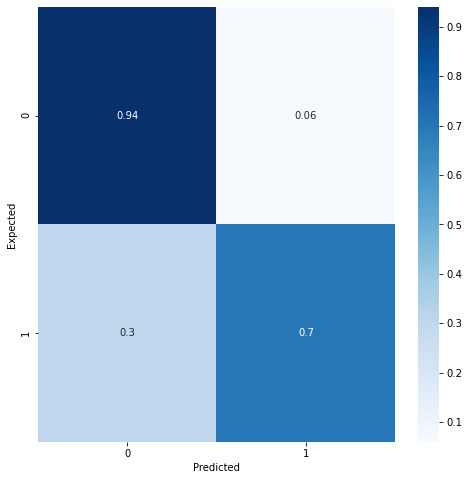

In [70]:
plot_balanced_accuracy_heatmap(y_train, y_pred_train)

## Random Forest

In [83]:
pred_dicts = []
depths = np.arange(1, 11)

for depth in depths:

    rf_classificer = RandomForestClassifier(max_depth = depth, criterion= 'entropy', random_state=42)
    rf_classificer.fit(X_train, y_train)

    train_pred = rf_classificer.predict(X_train)
    val_pred = rf_classificer.predict(X_val)

    prediction = {
        'depth': depth,
        'train_bal_accuracy': balanced_accuracy_score(y_train, train_pred),
        'val_bal_accuracy': balanced_accuracy_score(y_val, val_pred)
    }

    pred_dicts.append(prediction)

rf_df = pd.DataFrame(pred_dicts)

<AxesSubplot:xlabel='depth'>

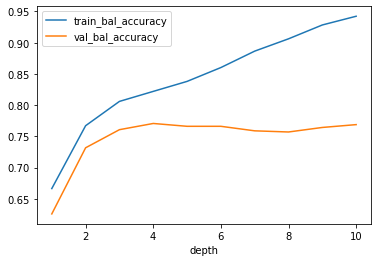

In [85]:
rf_df.set_index('depth').plot()

In [86]:
rf_df[rf_df['val_bal_accuracy'] == rf_df['val_bal_accuracy'].max()]

,depth,train_bal_accuracy,val_bal_accuracy
3,4,0.822036,0.770685


## Saving output to competition

In [129]:
X_test_scaled = scaler.transform(X_test)
y_pred_test = best_svc.predict(X_test_scaled)

In [130]:
output = test_set.copy()
output['Survived'] = y_pred_test
output = output[['PassengerId', 'Survived']]

In [131]:
output.to_csv('my_submission.csv', index=False)

The score obtained was 0.73205.

Since we have an unbalanced dataset with around 40% of survivors, we could try using some undersampling or oversampling techniques to get better results, because if we take a look at the confusion matrices, is the survivor class predictions that is harming our balanced accuracy.